In [1]:
import pandas as pd
import numpy as np
import os
from nice_funcs.indicators import CreateRandomPrtf,EWMA,MACD,RSI,NormalizeWindow,MDD,SharpeRatio
from stable_baselines3 import DDPG ,PPO
from ambiente import TradingEnv
import matplotlib.pyplot as plt 


    

def GetIndex(*args):
  indicators = [*args]
  index_init = set(indicators[0].index)
  for ind_ in indicators:
    index_init = index_init & set(ind_.index)
  
  idx_date = min(index_init)
  new_index_indicators = []
  for ind_ in indicators:
    ind_['Cash'] = 0 
    new_index_indicators.append(ind_[idx_date:])
  return new_index_indicators
        


file = './assets/United States 10-Year Bond Yield Historical Data.csv'
close_price_free = pd.read_csv(file).Price
risk_free_rate = close_price_free.mean()/100
daily_risk_free = (1+risk_free_rate)**1/252

path_diario = './assets/1d/'
ativos = os.listdir(path_diario)

ativosOHLC = {}
for ativo in ativos:
    ativosOHLC[ativo.replace('.xlsx','')] = \
        pd.read_excel(os.path.join(path_diario,ativo),index_col=0)
    

close_prices = {}
for k in ativosOHLC.keys():
  close_prices[k] = ativosOHLC[k].Close



df_fechamento = pd.DataFrame(close_prices).iloc[-360:]
normalized_fech = df_fechamento.apply(lambda row: NormalizeWindow(row)).dropna()
macd = df_fechamento.apply(lambda row: MACD(row)[0]).dropna()
rsi = df_fechamento.apply(lambda row: RSI(row)).dropna()
ewma_diff = df_fechamento.apply(lambda row: EWMA(row,20) - EWMA(row,5)).dropna()
ddd = df_fechamento.apply(lambda row: MDD(row,window=26)[0]).dropna()
mdd = df_fechamento.apply(lambda row: MDD(row,window=26)[0]).rolling(window=26).min().dropna()
df_fechamento,normalized_fech,macd,rsi,ewma_diff,ddd,mdd =  GetIndex(df_fechamento,normalized_fech, macd, rsi, ewma_diff,ddd,mdd)






env = TradingEnv(df_fechamento,[normalized_fech,macd,rsi,ewma_diff,ddd,mdd],daily_risk_free,'s')

In [2]:
model = PPO.load('./Training/Saved Models/trading_5.zip') 
#model = PPO.load('./Training/Logs/best_model.zip')

In [3]:
stats = {
  'ganho_total':[],
  'total_turnos':[],
  'prtf':[],
  'valor':[]}
for _ in range(1):
  obs,_ = env.reset()
  total_ganho = 0
  done = False
  truncated = False
  termination = (done or truncated)
  acoes = []
  rewards = []
  while not termination:
      action,_ = model.predict(obs,deterministic=True)
      obs,reward, done ,truncated,info = env.step(action)
      total_ganho +=reward
      termination = (done or truncated)
      if sum(action) != 0:
         action = action/sum(action)
      else:
         action = env.softmax_normalization(action)
      acoes.append(action)
      rewards.append(reward)
  stats['ganho_total'].append(total_ganho)
  stats['total_turnos'].append(env.step_)
  stats['prtf'].append(acoes)
  stats['valor'].append(rewards)

**************************************************
Retorno 1000
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.12993695251851667
0.16945788774709636
0.09061640001846981
0.09652606168890876
0.06767855895061542
0.038392508128063406
0.03165579770265251
-0.009950425806971943
0.04450095869808829
0.06137040899574183
0.11165856495965978
0.07559865505599475
0.024540627209862272
0.08845543643124697
0.053443001247471554
-0.022412201736293786
0.02249020492044178
-0.28312669349649944
-0.34702701563724037
-0.2693543187471254
-0.29067700450069023
-0.2683470532600645
-0.1786447531952112
-0.25472143718592477
-0.4542895248896585
-0.4425459430153578
-0.34095268960018354
-0.256596735205496
-0.3027718449043917
-0.48476474851938145
-0.4071617865903965
-0.29603809204463266
-0.32012495344940745
-0.25631192528807506
-0.2190073738613181
-0.1331482183304625
-0.06666924391084657
-0.09085799419046965
-0.043395661994569505
-0.019399327463118766
0.1483917828707112
0.137005265254348
0.

In [4]:
xxxxx

NameError: name 'xxxxx' is not defined

In [ ]:
x = (pd.Series(stats['valor'][0]).cumsum() +1000).pct_change().describe()

In [ ]:
#sharpe
(x['mean']/x['std'])*np.sqrt(252)

1.1035241711028478

In [ ]:
portfolio_value = stats['valor'][0]
portfolio_value = pd.Series(([1000,*portfolio_value])).cumsum()
portfolio_weights = pd.DataFrame([np.zeros(stats['prtf'][0][0].shape,dtype='int32'), *stats['prtf'][0]],columns=df_fechamento.columns)

<Axes: >

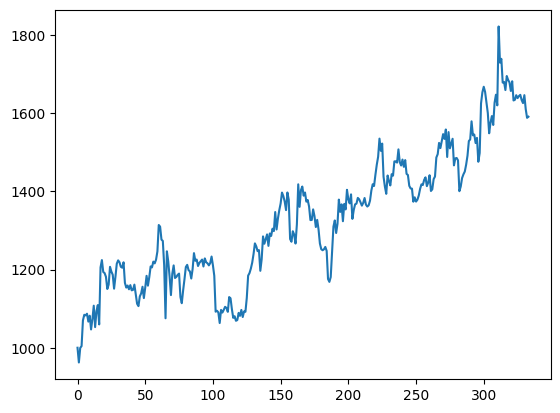

In [ ]:
portfolio_value.plot()

In [ ]:
returns = df_fechamento.pct_change().iloc[1:].fillna(0)
log_returns = np.log(1+returns)
equal_pesos = [1/len(log_returns.columns)]*len(log_returns.columns)
prtf_returns = (log_returns * equal_pesos).sum(axis=1)
buy_n_hold = np.exp(prtf_returns.cumsum())*1000

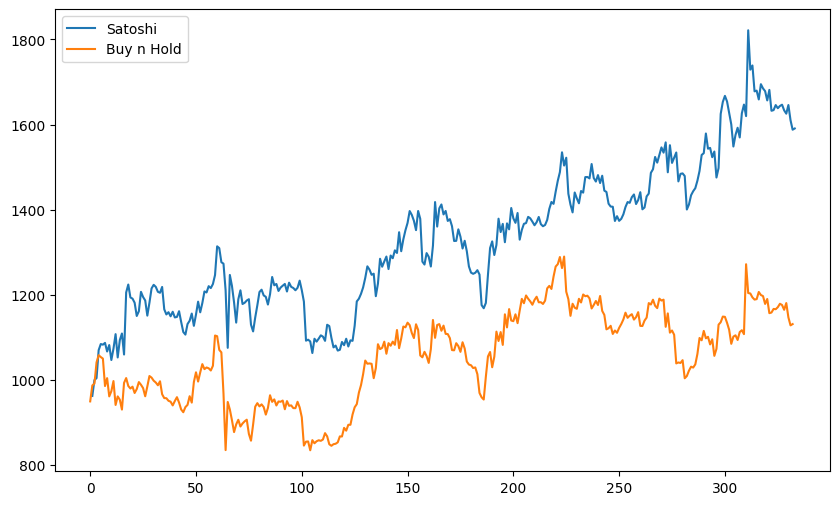

In [ ]:
portfolio_value.iloc[1:].plot(label='Satoshi',figsize=(10,6))
plt.plot(buy_n_hold.values,label='Buy n Hold')
plt.legend()

<Axes: >

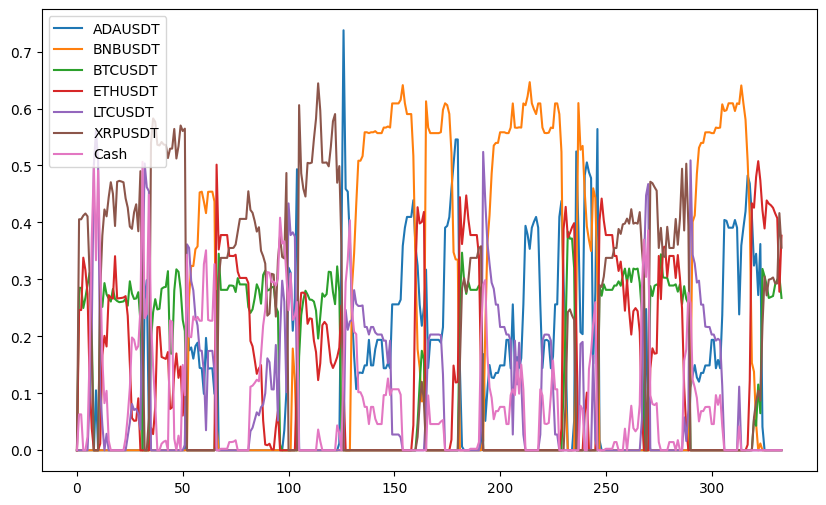

In [ ]:
portfolio_weights.plot(figsize=(10,6))

In [ ]:
# retorno de 59% a.a